In [ ]:
!pip install apyori

  Preparing metadata (setup.py) ... done
  Created wheel for apyori: filename=apyori-1.1.2-py3-none-any.whl size=5954 sha256=5bfaaee19968d1fa522d576ee34f24a0d4779589b2f3a139b2b08938fe8c123c
  Stored in directory: /root/.cache/pip/wheels/c4/1a/79/20f55c470a50bb3702a8cb7c94d8ada15573538c7f4baebe2d
Successfully built apyori


In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
import apyori
from apyori import apriori
import hashlib
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate


In [ ]:
#Carregando os dados de vendas localizados na mesma pasta do script
df = pd.read_excel('Vendas_Ecom.xlsx')

count_row = df.shape[0]  # Número de Linhas
count_col = df.shape[1]  # Número de Colunas
print('Linhas:', count_row, ' com ', count_col, 'colunas')

# Exibir os nomes dos campos e seus tipos
print(df.dtypes)

# Anonimizando o campo e-mail , sem perder a referência para evitar a exposição dos dados do comprador
df['Email'] = df['Email'].apply(lambda x: hashlib.sha256(x.encode('utf-8')).hexdigest())

# Selecionando as colunas desejadas para visualizar
selected_columns = df[['Email', 'order_id','item_sku','item_name','item_quantity','item_total','Subtotal','Total','order_status','Created at']].head()

# Salvando o conteúdo das colunas selecionadas e Email anonimizado para futuras consultas ou estudos posteriores
selected_columns.to_csv('selected_columns.csv', index=False)

# Convertendo o DataFrame em uma lista de dicionários
data_as_dicts = selected_columns.to_dict('records')

# Exibindo os dados em formato de tabela
print(tabulate(data_as_dicts, headers="keys", tablefmt="pretty"))

Linhas: 4656  com  58 colunas
order_id                         int64
Email                           object
order_status                    object
Paid at                         object
Accepts Marketing               object
Currency                        object
Subtotal                       float64
Shipping                       float64
Taxes                          float64
Total                          float64
Discount Code                   object
Discount Amount                float64
Shipping Method                 object
Created at                      object
item_quantity                    int64
item_name                       object
item_total                     float64
Lineitem compare at price      float64
item_sku                        object
Lineitem requires shipping        bool
Lineitem taxable                  bool
Lineitem fulfillment status     object
Billing first name              object
Billing last name               object
Billing Phone                   ob

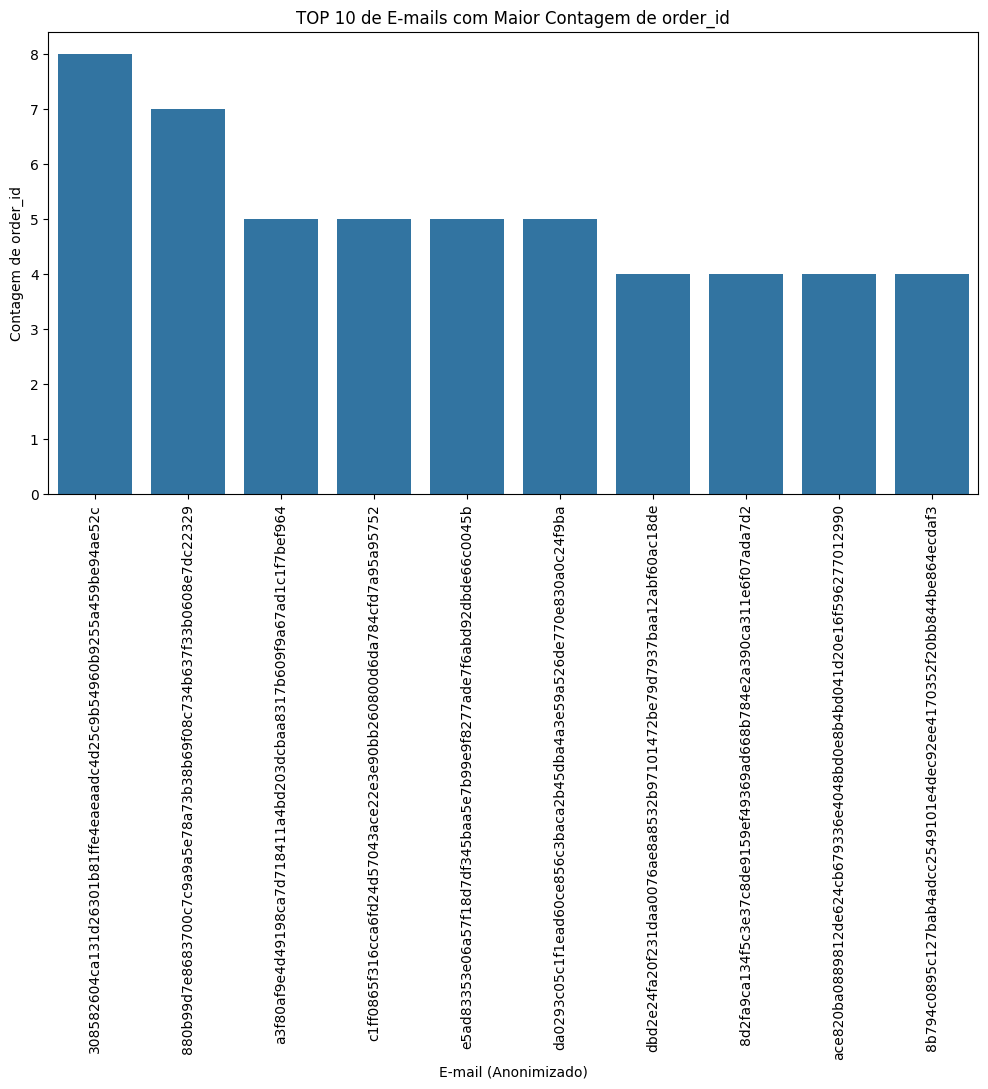

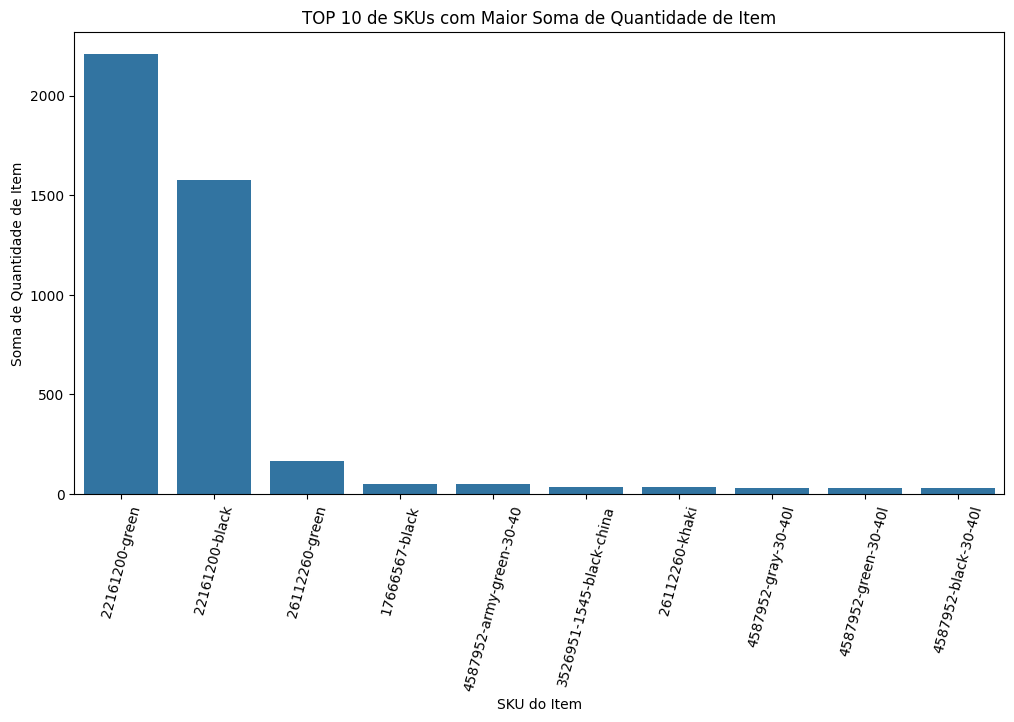

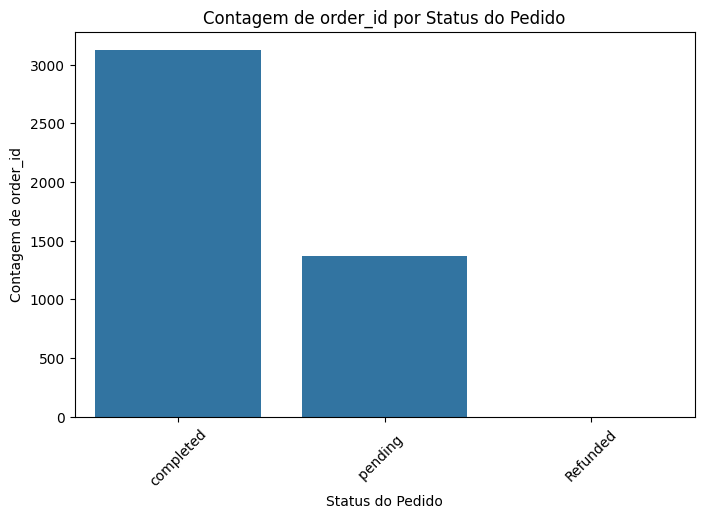

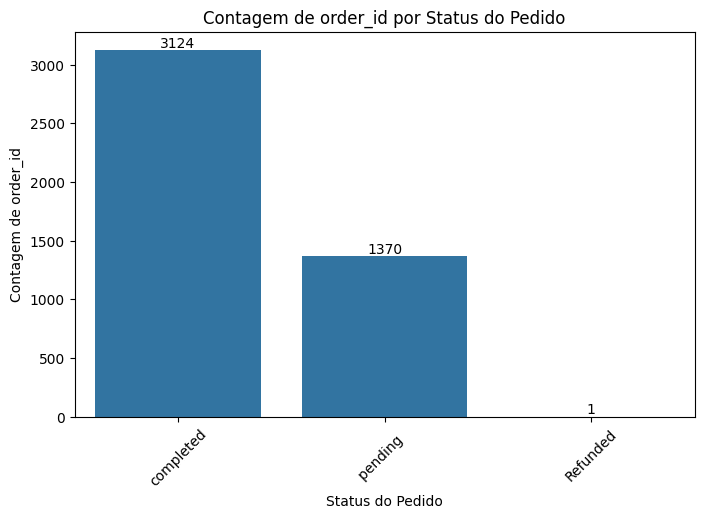

In [ ]:
# Criando os gráficos

# Gráfico de barras Email x count de 'order_id' (TOP 10)
plt.figure(figsize=(12, 6))
top_emails = df['Email'].value_counts().head(10)
sns.barplot(x=top_emails.index, y=top_emails.values)
plt.xlabel('E-mail (Anonimizado)')
plt.ylabel('Contagem de order_id')
plt.title('TOP 10 de E-mails com Maior Contagem de order_id')
plt.xticks(rotation=90)
plt.show()

# Gráfico de barras item_sku x soma de item_quantity (TOP 10)
plt.figure(figsize=(12, 6))
top_skus = df.groupby('item_sku')['item_quantity'].sum().nlargest(10)
sns.barplot(x=top_skus.index, y=top_skus.values)
plt.xlabel('SKU do Item')
plt.ylabel('Soma de Quantidade de Item')
plt.title('TOP 10 de SKUs com Maior Soma de Quantidade de Item')
plt.xticks(rotation=75)
plt.show()

# Gráfico de barras para 'order_status' x contagem de 'order_id'
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=df, x='order_status')
plt.xlabel('Status do Pedido')
plt.ylabel('Contagem de order_id')
plt.title('Contagem de order_id por Status do Pedido')
plt.xticks(rotation=45)

# Adicionando os números máximos acima das barras
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

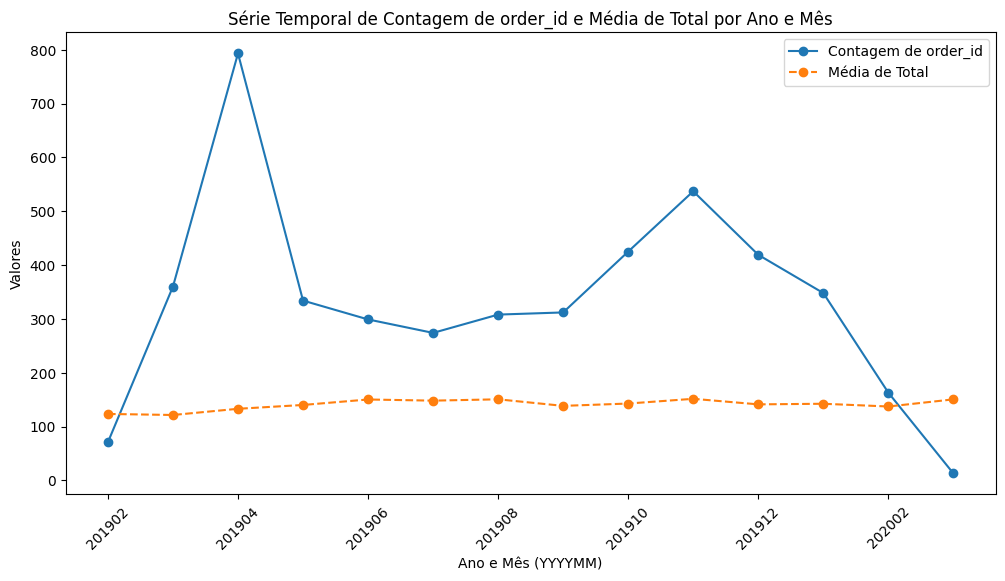

In [ ]:
# Convertendo 'Created at' para o formato de data (considerando o fuso horário UTC)
df['Created at'] = pd.to_datetime(df['Created at'], errors='coerce', utc=True)

# Removendo linhas com valores de data nulos (caso haja)
df = df.dropna(subset=['Created at'])

# Criando uma série temporal de 'order_id' por ano/mês (YYYYMM)
df['YearMonth'] = df['Created at'].dt.strftime('%Y%m')

# Gráfico de linha para 'order_id' ao longo do tempo (ano/mês) - Contagem de order_id
plt.figure(figsize=(12, 6))
df.groupby('YearMonth')['order_id'].count().plot(kind='line', marker='o', label='Contagem de order_id')

# Gráfico de linha para a média da coluna 'Total' ao longo do tempo (ano/mês)
df.groupby('YearMonth')['Total'].mean().plot(kind='line', marker='o', label='Média de Total', linestyle='dashed')

plt.xlabel('Ano e Mês (YYYYMM)')
plt.ylabel('Valores')
plt.title('Série Temporal de Contagem de order_id e Média de Total por Ano e Mês')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [ ]:
df['Total'].mean()


141.76447183098594

In [ ]:
# Mantendo apenas as concluídas
df = df[df['order_status'] == 'completed']
df = df.dropna(subset=['item_name'])


#Ajustando SKU para char e evitar erros de compatibilidade de str e float
df['item_sku'] = df['item_sku'].astype(str)


In [ ]:
print("Top 10 Vendas)")
x = df['item_name'].value_counts().sort_values(ascending=False)[:10]
fig = px.bar(x= x.index, y= x.values)
fig.update_layout(title_text= "Top 10 Produtos mais vendidos", xaxis_title= "Produtos", yaxis_title="Vendidos")
fig.show()

Top 10 Vendas)


Preparando a lista para entrada no algorítimo  Apriori

In [ ]:
# Agrupando os itens por transação
grouped = df.groupby('Email')['item_sku'].apply(list)

# Convertendo o DataFrame agrupado em uma lista de transações
transactions = list(grouped)

# Converter números inteiros para strings
transactions_as_strings = []

for transaction in transactions:
    transaction_as_string = [str(item) for item in transaction]
    transactions_as_strings.append(transaction_as_string)


# print(transactions)
print(transactions_as_strings)


[['22161200-black'], ['22161200-black'], ['22161200-black'], ['22161200-black'], ['22161200-black'], ['22161200-green'], ['22161200-black', '22161200-black'], ['22161200-green'], ['22161200-green'], ['22161200-green'], ['22161200-black'], ['22161200-black'], ['26112260-green'], ['13199838-green'], ['22161200-green'], ['22161200-green'], ['22161200-green'], ['22161200-green'], ['22161200-black'], ['22161200-black'], ['22161200-green'], ['22161200-black'], ['22161200-black'], ['22161200-green'], ['22161200-green'], ['22161200-black'], ['19040980-sunglasses', '22161200-green'], ['22161200-green'], ['22161200-green'], ['22161200-green'], ['9616915-black-china-m'], ['22161200-black'], ['22161200-green'], ['22161200-black'], ['22161200-black'], ['22161200-black'], ['22161200-black'], ['22161200-green'], ['22161200-green'], ['22161200-black'], ['22161200-green'], ['22161200-green'], ['preto'], ['22161200-green'], ['26112260-green'], ['22161200-black'], ['22161200-black'], ['22161200-black'], 

Parâmetros utilizados na função apriori:

transactions: Este é o conjunto de dados de entrada para o algoritmo Apriori. Como mencionado anteriormente, deve ser uma lista de transações, onde cada transação é uma lista dos itens comprados.

min_support: O suporte mínimo é um dos principais parâmetros do algoritmo Apriori. Ele define o limite mínimo para considerar um itemset (conjunto de itens) como "frequente" no conjunto de dados. O suporte de um itemset é calculado como a proporção de transações no conjunto de dados que contêm esse itemset. Por exemplo, um min_support de 0.0005 significa que um itemset precisa aparecer em pelo menos 0.05% de todas as transações para ser considerado no processo de mineração de regras.

min_confidence: A confiança mínima é outro parâmetro crucial. É usado para medir a confiabilidade de uma regra de associação inferida. A confiança é a proporção de vezes que, se o lado esquerdo de uma regra (antecedente) aparece em uma transação, o lado direito da regra (consequente) também aparece. Um min_confidence de 0.05 significa que apenas as regras de associação com uma confiança de pelo menos 5% serão consideradas.

min_lift: O lift é uma métrica que compara a confiança de uma regra com a expectativa de que os itens apareçam juntos se fossem independentes. Um min_lift de 3 indica que você está interessado apenas em regras onde a probabilidade de ocorrência conjunta dos itens é pelo menos três vezes maior do que seria se fossem independentes.

max_length: Este parâmetro define o tamanho máximo dos itemsets a serem considerados. Por exemplo, um max_length de 2 significa que o algoritmo só considerará itemsets contendo no máximo dois itens. Isso é útil para limitar a complexidade das regras geradas e focar em relações mais simples.

target="rules": Este parâmetro indica o tipo de itemset que você está interessado em encontrar. Neste caso, "rules" significa que você está interessado em encontrar regras de associação, não apenas conjuntos frequentes de itens.

In [ ]:
# Agora você pode aplicar o algoritmo Apriori para 2 produtos
# com suporte mínimo de 0.05% , um mínimo de confiança de 25% e um lift
rules = apriori(transactions_as_strings, min_support=(0.02/100), min_confidence=(10/100), min_lift=3, max_length=2, target="rules")
association_results = list(rules)
print(association_results[0])


RelationRecord(items=frozenset({'13199838-black', '3526951-1545-black-silver-china'}), support=0.00032754667540124465, ordered_statistics=[OrderedStatistic(items_base=frozenset({'13199838-black'}), items_add=frozenset({'3526951-1545-black-silver-china'}), confidence=0.125, lift=127.20833333333334), OrderedStatistic(items_base=frozenset({'3526951-1545-black-silver-china'}), items_add=frozenset({'13199838-black'}), confidence=0.3333333333333333, lift=127.20833333333333)])


Esta é uma regra de associação típica gerada por algoritmos como Apriori ou FP-Growth, e cada parte do registro fornece informações úteis sobre a relação entre os itens em seu conjunto de dados.

Aqui está a decomposição e explicação do seu `RelationRecord`:

1. **items=frozenset({100000, 100004})**:
   - Este é o conjunto de itens na regra de associação. Neste caso, os itens são 100000 e 100004. A estrutura `frozenset` é usada porque é uma coleção imutável e hashable em Python.

2. **support=0.001302295295458245**:
   - O suporte é a proporção de transações no conjunto de dados que contêm todos os itens no conjunto de itens. Aqui, 0.0013 significa que os itens 100000 e 100004 aparecem juntos em aproximadamente 0.13% de todas as transações.

3. **ordered_statistics**:
   - Esta é uma lista de `OrderedStatistic`, que fornece informações mais detalhadas sobre a regra de associação.

   - **OrderedStatistic(items_base=frozenset({100000}), items_add=frozenset({100004}), confidence=0.06451612903225806, lift=4.2161976664378855)**:
     - `items_base` são os itens antecedentes (a base) da regra. Neste caso, é o item 100000.
     - `items_add` são os itens consequentes da regra. Aqui, é o item 100004.
     - `confidence` de 0.0645 significa que, das transações que contêm o item 100000, aproximadamente 6.45% também contêm o item 100004.
     - `lift` de 4.216 indica que a probabilidade de 100004 e 100000 serem comprados juntos é 4.216 vezes maior do que a probabilidade de 100004 ser comprado, assumindo que 100000 e 100004 são independentes.

   - **OrderedStatistic(items_base=frozenset({100004}), items_add=frozenset({100000}), confidence=0.0851063829787234, lift=4.216197666437886)**:
     - Esta é a mesma relação, mas na direção oposta. Aqui, 100004 é o item base e 100000 é o item adicionado.
     - `confidence` de 0.0851 significa que, das transações que contêm o item 100004, aproximadamente 8.51% também contêm o item 100000.

Este `RelationRecord` sugere que há uma relação positiva entre a compra dos itens 100000 e 100004, embora a confiança seja relativamente baixa (o que é normal em muitos conjuntos de dados de varejo devido à grande variedade de combinações de itens possíveis). O `lift` maior que 1 sugere que há uma relação mais forte entre esses itens do que se eles fossem independentes.

In [ ]:
# Lista para armazenar os resultados
results = []

for item in association_results:
    pair = item[0]
    items = [x for x in pair]

    # Adicionando os resultados à lista
    results.append({
        'Rule': f"{items[0]} -> {items[1]}",
        'Support': item[1],
        'Confidence': item[2][0][2],
        'Lift': item[2][0][3]
    })

    # Exibir os resultados
    print(f"Rule : {items[0]} -> {items[1]}")
    print(f"Support : {item[1]}")
    print(f"Confidence : {item[2][0][2]}")
    print(f"Lift : {item[2][0][3]}")
    print("=============================")

# Convertendo a lista em DataFrame
results_df = pd.DataFrame(results)

# Salvando o DataFrame em um arquivo CSV
results_df.to_csv('association_rulesEcom.csv', index=False)

Rule : 13199838-black -> 3526951-1545-black-silver-china
Support : 0.00032754667540124465
Confidence : 0.125
Lift : 127.20833333333334
Rule : 26112260-green -> 16058326-army-camouflage
Support : 0.00032754667540124465
Confidence : 1.0
Lift : 29.076190476190472
Rule : 26256057-green -> 17666567-black
Support : 0.00032754667540124465
Confidence : 0.125
Lift : 9.78525641025641
Rule : 4587952-army-green-30-40 -> 18379073-army-green-l
Support : 0.00032754667540124465
Confidence : 1.0
Lift : 101.76666666666667
Rule : 18379073-black-l -> 4587952-40l-army-green-30-40l-china
Support : 0.00032754667540124465
Confidence : 0.3333333333333333
Lift : 339.22222222222223
Rule : 4587952-black-30-40l -> 18379073-black-m
Support : 0.00032754667540124465
Confidence : 0.16666666666666666
Lift : 26.780701754385962
Rule : 4587952-gray-30-40l -> 18379073-black-m
Support : 0.00032754667540124465
Confidence : 0.16666666666666666
Lift : 28.26851851851852
Rule : 19040980-sunglasses -> preto
Support : 0.0003275466

Regra: Isso indica a regra de associação entre os itens. Por exemplo, "13199838-green -> 19768167-od" significa que a presença do item "13199838-green" em uma transação está associada à presença do item "19768167-od" na mesma transação.

Support (Suporte): O suporte mede a frequência com que uma regra ocorre nas transações. Ele é calculado como a proporção de transações que contêm a combinação dos itens da regra. Por exemplo, "Support: 0.000481" significa que a regra ocorre em aproximadamente 0.0481% das transações.

Confidence (Confiança): A confiança mede a probabilidade de que a presença do item do lado esquerdo da regra (antecedente) implique na presença do item do lado direito (consequente). Por exemplo, "Confiança: 0.111" significa que, em 11.1% das vezes em que "13199838-green" está presente, "19768167-od" também está presente na mesma transação.

Lift: O lift mede o quão mais provável é que a regra seja verdadeira em comparação com o que seria se os itens fossem independentes. Um lift maior que 1 indica uma associação positiva, onde os itens aparecem juntos com mais frequência do que o esperado, enquanto um lift menor que 1 indica uma associação negativa, onde os itens aparecem juntos menos frequentemente do que o esperado. Por exemplo, "Lift: 17.756" indica uma forte associação positiva entre "13199838-green" e "19768167-od", pois o lift é muito maior que 1.



Observando para 3 produtos

- `min_support=0.00030`: Define o suporte mínimo como 0.00030. Isso significa que um conjunto de itens precisa aparecer em pelo menos 0.03% de todas as transações para ser considerado.

- `min_confidence=0.05`: Estabelece a confiança mínima como 0.05. Uma regra de associação deve ter uma confiança de pelo menos 5% para ser incluída nos resultados.

- `min_lift=3`: Determina o lift mínimo como 3. Isso significa que você está interessado em regras onde os itens são pelo menos três vezes mais prováveis de serem comprados juntos do que seriam se fossem independentes.

- `max_length=3`: Especifica que o tamanho máximo de qualquer conjunto de itens considerado pelo algoritmo é de 3. Isso significa que o algoritmo irá gerar regras de associação considerando combinações de até 3 produtos.

- `target="rules"`: Indica que o objetivo da análise é encontrar regras de associação, não apenas conjuntos de itens frequentes.

Portanto, com essas configurações, o algoritmo Apriori irá gerar regras de associação que envolvem até 3 produtos e que atendem aos critérios de suporte mínimo, confiança mínima e lift mínimo que você definiu.

In [ ]:
# Agora você pode aplicar o algoritmo Apriori
rules = apriori(transactions_as_strings, min_support=0.00030, min_confidence=0.05, min_lift=3, max_length=3, target="rules")
association_results = list(rules)
print(association_results[0])

RelationRecord(items=frozenset({'13199838-green', '19768167-od'}), support=0.0004813477737665463, ordered_statistics=[OrderedStatistic(items_base=frozenset({'13199838-green'}), items_add=frozenset({'19768167-od'}), confidence=0.1111111111111111, lift=17.756410256410255), OrderedStatistic(items_base=frozenset({'19768167-od'}), items_add=frozenset({'13199838-green'}), confidence=0.07692307692307693, lift=17.75641025641026)])


In [ ]:
#import pandas as pd

# Lista para armazenar os resultados
results = []

for item in association_results:
    items = list(item[0])

    # Construir a string de regra dependendo do número de itens
    rule = " -> ".join(items)

    # Adicionando os resultados à lista
    results.append({
        'Rule': rule,
        'Support': item[1],
        'Confidence': item[2][0][2],
        'Lift': item[2][0][3]
    })

    # Exibir os resultados
    print(f"Rule: {rule}")
    print(f"Support: {item[1]}")
    print(f"Confidence: {item[2][0][2]}")
    print(f"Lift: {item[2][0][3]}")
    print("=============================")

# Convertendo a lista em DataFrame
results_df = pd.DataFrame(results)

# Salvando o DataFrame em um arquivo CSV
results_df.to_csv('association_rulesEcom3.csv', index=False)


Rule: 13199838-green -> 19768167-od
Support: 0.0004813477737665463
Confidence: 0.1111111111111111
Lift: 17.756410256410255
Rule: 4587952-40l-green-30-40l-china -> 13199838-green
Support: 0.0004813477737665463
Confidence: 0.1111111111111111
Lift: 28.854166666666668
Rule: 16058326-black -> 17666567-black
Support: 0.0004813477737665463
Confidence: 0.19999999999999998
Lift: 16.959183673469386
Rule: 18379073-army-green-m -> 19768167-od
Support: 0.0004813477737665463
Confidence: 0.25
Lift: 39.95192307692308
Rule: 4587952-gray-30-40l -> 18379073-black-m
Support: 0.0007220216606498195
Confidence: 0.23076923076923075
Lift: 30.930521091811414
Rule: 19768167-od -> 19768167-tan
Support: 0.0007220216606498195
Confidence: 0.11538461538461538
Lift: 68.48901098901098
Rule: 26256057-green -> 26256057-camo
Support: 0.0004813477737665463
Confidence: 0.39999999999999997
Lift: 127.84615384615384
Rule: 4587952-black-30-40l -> 4587952-army-green-30-40
Support: 0.0004813477737665463
Confidence: 0.071428571428

Aqui está uma análise dos resultados das regras de associação encontradas:

1. **Regra: 13199838-green -> 19768167-od**
   - **Support**: 0.000481 (cerca de 0.0481% das transações)
   - **Confiança**: 0.111 (11.1% de confiança)
   - **Lift**: 17.756 (forte associação positiva)
   - **Análise**: Essa regra indica que quando o item "13199838-green" está presente em uma transação, há uma alta probabilidade (11.1%) de que o item "19768167-od" também esteja presente. O alto valor de lift sugere uma forte associação entre esses dois itens.

2. **Regra: 4587952-40l-green-30-40l-china -> 13199838-green**
   - **Support**: 0.000481 (cerca de 0.0481% das transações)
   - **Confiança**: 0.111 (11.1% de confiança)
   - **Lift**: 28.854 (forte associação positiva)
   - **Análise**: Essa regra indica que quando o item "4587952-40l-green-30-40l-china" está presente em uma transação, há uma alta probabilidade (11.1%) de que o item "13199838-green" também esteja presente. O alto valor de lift sugere uma forte associação entre esses dois itens.

3. **Regra: 16058326-black -> 17666567-black**
   - **Support**: 0.000481 (cerca de 0.0481% das transações)
   - **Confiança**: 0.2 (20% de confiança)
   - **Lift**: 16.959 (forte associação positiva)
   - **Análise**: Essa regra indica que quando o item "16058326-black" está presente em uma transação, há uma alta probabilidade (20%) de que o item "17666567-black" também esteja presente. O alto valor de lift sugere uma forte associação entre esses dois itens.

4. **Regra: 18379073-army-green-m -> 19768167-od**
   - **Support**: 0.000481 (cerca de 0.0481% das transações)
   - **Confiança**: 0.25 (25% de confiança)
   - **Lift**: 39.952 (forte associação positiva)
   - **Análise**: Essa regra indica que quando o item "18379073-army-green-m" está presente em uma transação, há uma alta probabilidade (25%) de que o item "19768167-od" também esteja presente. O alto valor de lift sugere uma forte associação entre esses dois itens.

5. **Regra: 4587952-gray-30-40l -> 18379073-black-m**
   - **Support**: 0.000722 (cerca de 0.0722% das transações)
   - **Confiança**: 0.231 (23.1% de confiança)
   - **Lift**: 30.931 (forte associação positiva)
   - **Análise**: Essa regra indica que quando o item "4587952-gray-30-40l" está presente em uma transação, há uma alta probabilidade (23.1%) de que o item "18379073-black-m" também esteja presente. O alto valor de lift sugere uma forte associação entre esses dois itens.

6. **Regra: 19768167-od -> 19768167-tan**
   - **Support**: 0.000722 (cerca de 0.0722% das transações)
   - **Confiança**: 0.115 (11.5% de confiança)
   - **Lift**: 68.489 (forte associação positiva)
   - **Análise**: Essa regra indica que quando o item "19768167-od" está presente em uma transação, há uma alta probabilidade (11.5%) de que o item "19768167-tan" também esteja presente. O alto valor de lift sugere uma forte associação entre esses dois itens.

7. **Regra: 26256057-green -> 26256057-camo**
   - **Support**: 0.000481 (cerca de 0.0481% das transações)
   - **Confiança**: 0.4 (40% de confiança)
   - **Lift**: 127.846 (forte associação positiva)
   - **Análise**: Essa regra indica que quando o item "26256057-green" está presente em uma transação, há uma alta probabilidade (40%) de que o item "26256057-camo" também esteja presente. O alto valor de lift sugere uma forte associação entre esses dois itens.

8. **Regra: 4587952-black-30-40l -> 4587952-army-green-30-40**
   - **Support**: 0.000481 (cerca de 0.0481% das transações)
   - **Confiança**: 0.071 (7.1% de confiança)
   - **Lift**: 6.452 (forte associação positiva)
   - **Análise**: Essa regra indica que quando o item "4587952-black-30-40l" está presente em uma transação, há uma probabilidade moderada (7.1%) de que o item "4587952-army-green-30-40" também esteja presente. O valor de lift sugere uma associação positiva entre esses itens, mas menos forte em comparação com outras regras.